In [64]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from rules import standard_deviation_rankings, divisiveness, win_rate, bootstrap3, bootstrap4, copeland, divisiveness_copeland, using_preflib, data_transform
import math
import warnings; warnings.simplefilter('ignore')
def get_kendall(x, c1, c2):
    return pd.DataFrame([x[c1],x[c2]]).T.corr(method='kendall')[1].values[0]


# This is a toy example for the experiment 1

In [65]:
# Initialize your experiments
METHOD = 'UM10'
N_PROFILES = 1
N_MINIMUM_ISSUES = 3
N_MAXIMUM_ISSUES = 18
RANGE_NUMBER_AGENTS = [100]

In [66]:
results = []

for profile in range(N_PROFILES):
    
    print("Running profile: ", profile)
    
    for number_issues in range(N_MINIMUM_ISSUES,N_MAXIMUM_ISSUES+1):

        for number_agents in RANGE_NUMBER_AGENTS:
            
            # Create the population using the selected method and the number of issues and agents
            all_rankings = using_preflib(number_issues, number_agents, type_=METHOD)
            
            # Transform the rankings into pairwise comparisons 
            # and put in the correct format for running the voting rule
            output = data_transform(all_rankings)
            data = pd.concat(output).reset_index(drop=True)
            data["id"] = range(1, data.shape[0] + 1)
            data["selected"] = data["option_a"]
            data["option_a_sorted"] = data[["option_a", "option_b"]].min(axis=1).astype(int)
            data["option_b_sorted"] = data[["option_a", "option_b"]].max(axis=1).astype(int)
            data["card_id"] = data["option_a_sorted"].astype(str) + "_" + data["option_b_sorted"].astype(str)
            a = data[["option_a", "option_b", "selected"]].values
            data["option_source"] = np.where(a[:, 1] == a[:, 2], a[:, 0], a[:, 1])
            data["option_target"] = np.where(a[:, 0] == a[:, 2], a[:, 0], a[:, 1])
            
            # Run each voting rule with the created profile
            df_win_rate = bootstrap4(data, win_rate, iterations=1, 
                                     aggregate=False, rank=True, rank_column="rank")
            ranked_win_rate = list(df_win_rate.sort_values(by='value', ascending=False)['id'].values)
    
            df_copeland = bootstrap4(data, copeland, iterations=1, 
                                     aggregate=False, rank=True, rank_column="rank")
            ranked_copeland = list(df_copeland.sort_values(by='value', ascending=False)['id'].values)

            df_divisiveness_win_rate = bootstrap4(data, divisiveness, iterations=1, 
                                         aggregate=False, rank=True, rank_column="rank")
            ranked_divisiveness_win_rate = list(df_divisiveness_win_rate.sort_values(by='value', ascending=False)['id'].values)
    
            df_divisiveness_copeland = bootstrap4(data, divisiveness_copeland, iterations=1, 
                                         aggregate=False, rank=True, rank_column="rank")
            ranked_divisiveness_copeland = list(df_divisiveness_copeland.sort_values(by='value', ascending=False)['id'].values)

            df_std = standard_deviation_rankings(all_rankings)
            ranked_std = list(df_std.sort_values(by='value', ascending=False)['id'].values)

            del all_rankings 
            results.append([
                            number_issues, 
                            number_agents,
                            profile,
                            ranked_win_rate,
                            ranked_copeland,
                            ranked_std,
                            ranked_divisiveness_win_rate, 
                            ranked_divisiveness_copeland,])

    plot = pd.DataFrame(results, columns=['number_issues',
                                          'number_agents',
                                          'profile_id',
                                          'RANK(WR)',
                                          'RANK(COP)',
                                          'RANK(STD)',
                                          'RANK(DIV(WR))',
                                          'RANK(DIV(COP))'])
    
    plot.to_csv("data/results_complete_method_%s_profile_%s.csv"%(METHOD,N_PROFILES), index=False)


Running profile:  0


100%|██████████| 272/272 [00:02<00:00, 125.01it/s]


In [67]:
plot.head(10)

,number_issues,number_agents,number_profiles,RANK(WR),RANK(COP),RANK(STD),RANK(DIV(WR)),RANK(DIV(COP))
0,3,100,0,"[0, 2, 1]","[0, 2, 1]","[1, 0, 2]","[1, 0, 2]","[1, 0, 2]"
1,4,100,0,"[1, 2, 3, 0]","[1, 2, 3, 0]","[1, 2, 0, 3]","[1, 2, 0, 3]","[1, 2, 0, 3]"
2,5,100,0,"[3, 0, 4, 2, 1]","[3, 4, 0, 2, 1]","[0, 4, 1, 2, 3]","[0, 3, 4, 1, 2]","[0, 1, 4, 2, 3]"
3,6,100,0,"[1, 2, 5, 3, 0, 4]","[1, 5, 2, 0, 3, 4]","[0, 5, 1, 3, 4, 2]","[0, 5, 4, 1, 3, 2]","[0, 5, 1, 4, 3, 2]"
4,7,100,0,"[2, 6, 3, 0, 5, 4, 1]","[2, 6, 5, 0, 1, 3, 4]","[2, 5, 3, 4, 6, 1, 0]","[2, 5, 3, 4, 1, 6, 0]","[2, 5, 4, 3, 6, 1, 0]"
5,8,100,0,"[4, 6, 7, 5, 0, 1, 3, 2]","[6, 4, 7, 1, 3, 5, 0, 2]","[0, 3, 1, 7, 2, 5, 6, 4]","[0, 3, 1, 7, 2, 5, 6, 4]","[0, 1, 3, 2, 7, 6, 5, 4]"
6,9,100,0,"[5, 8, 6, 1, 0, 3, 2, 7, 4]","[5, 6, 8, 0, 3, 1, 7, 2, 4]","[5, 8, 6, 0, 1, 3, 2, 7, 4]","[5, 8, 6, 0, 1, 3, 2, 4, 7]","[5, 8, 6, 1, 0, 3, 7, 4, 2]"
7,10,100,0,"[9, 1, 8, 7, 6, 4, 2, 3, 5, 0]","[1, 9, 8, 6, 7, 4, 5, 2, 3, 0]","[4, 8, 7, 9, 0, 3, 2, 1, 5, 6]","[8, 4, 9, 7, 0, 3, 2, 1, 5, 6]","[7, 8, 9, 4, 0, 1, 3, 2, 5, 6]"
8,11,100,0,"[5, 0, 8, 6, 3, 4, 9, 7, 10, 2, 1]","[0, 5, 6, 3, 4, 8, 9, 7, 10, 2, 1]","[0, 1, 10, 4, 2, 8, 6, 5, 3, 7, 9]","[0, 1, 10, 2, 4, 5, 8, 6, 3, 7, 9]","[0, 1, 10, 5, 6, 2, 4, 3, 8, 7, 9]"
9,12,100,0,"[4, 11, 9, 1, 0, 8, 6, 5, 2, 10, 7, 3]","[4, 9, 11, 1, 8, 0, 6, 5, 2, 3, 10, 7]","[7, 6, 2, 9, 11, 10, 5, 1, 0, 3, 4, 8]","[7, 2, 6, 9, 11, 10, 5, 1, 3, 4, 0, 8]","[7, 9, 6, 2, 11, 10, 1, 5, 0, 3, 4, 8]"


In [68]:
df = pd.read_csv("data/results_complete_method_%s_profile_%s.csv"%(METHOD,N_PROFILES))
df['RANK(WR)'] = df['RANK(WR)'].apply(lambda x: eval(x))
df['RANK(STD)'] = df['RANK(STD)'].apply(lambda x: eval(x))
df['RANK(COP)'] = df['RANK(COP)'].apply(lambda x: eval(x))
df['RANK(DIV(WR))'] = df['RANK(DIV(WR))'].apply(lambda x: eval(x))
df['RANK(DIV(COP))'] = df['RANK(DIV(COP))'].apply(lambda x: eval(x))

In [69]:
df['KT(WR,STD)'] = df.apply(lambda x: get_kendall(x, c1='RANK(WR)', c2='RANK(STD)'), axis=1)
df['KT(WR,COP)'] = df.apply(lambda x: get_kendall(x, c1='RANK(WR)', c2='RANK(COP)'), axis=1)
df['KT(WR,RANK(DIV(WR)))'] = df.apply(lambda x: get_kendall(x, c1='RANK(WR)', c2='RANK(DIV(WR))'), axis=1)
df['KT(WR,RANK(DIV(COP)))'] = df.apply(lambda x: get_kendall(x, c1='RANK(WR)', c2='RANK(DIV(COP))'), axis=1)
df['KT(RANK(DIV(WR)),STD)'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(WR))', c2='RANK(STD)'), axis=1)
df['KT(RANK(DIV(WR)),COP)'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(WR))', c2='RANK(COP)'), axis=1)
df['KT(RANK(DIV(WR)),RANK(DIV(COP)))'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(WR))', c2='RANK(DIV(COP))'), axis=1)
df['KT(RANK(DIV(COP)),STD)'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(COP))', c2='RANK(STD)'), axis=1)
df['KT(RANK(DIV(COP)),COP)'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(COP))', c2='RANK(COP)'), axis=1)
df['KT(RANK(DIV(COP)),RANK(DIV(WR)))'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(COP))', c2='RANK(DIV(WR))'), axis=1)

In [70]:
df.to_csv("data/results_complete_method_%s_profile_%s_kendall.csv"%(METHOD,N_PROFILES), index=False)

In [71]:
df.head()

,number_issues,number_agents,number_profiles,RANK(WR),RANK(COP),RANK(STD),RANK(DIV(WR)),RANK(DIV(COP)),"KT(WR,STD)","KT(WR,COP)","KT(WR,RANK(DIV(WR)))","KT(WR,RANK(DIV(COP)))","KT(RANK(DIV(WR)),STD)","KT(RANK(DIV(WR)),COP)","KT(RANK(DIV(WR)),RANK(DIV(COP)))","KT(RANK(DIV(COP)),STD)","KT(RANK(DIV(COP)),COP)","KT(RANK(DIV(COP)),RANK(DIV(WR)))"
0,3,100,0,"[0, 2, 1]","[0, 2, 1]","[1, 0, 2]","[1, 0, 2]","[1, 0, 2]",-0.333333,1.000000,-0.333333,-0.333333,1.000000,-0.333333,1.000000,1.000000,-0.333333,1.000000
1,4,100,0,"[1, 2, 3, 0]","[1, 2, 3, 0]","[1, 2, 0, 3]","[1, 2, 0, 3]","[1, 2, 0, 3]",-0.666667,1.000000,-0.666667,-0.666667,1.000000,-0.666667,1.000000,1.000000,-0.666667,1.000000
2,5,100,0,"[3, 0, 4, 2, 1]","[3, 4, 0, 2, 1]","[0, 4, 1, 2, 3]","[0, 3, 4, 1, 2]","[0, 1, 4, 2, 3]",-0.800000,-0.400000,-0.200000,0.200000,0.400000,-0.400000,0.600000,0.000000,-0.800000,0.600000
3,6,100,0,"[1, 2, 5, 3, 0, 4]","[1, 5, 2, 0, 3, 4]","[0, 5, 1, 3, 4, 2]","[0, 5, 4, 1, 3, 2]","[0, 5, 1, 4, 3, 2]",-0.333333,-0.066667,0.200000,-0.200000,0.466667,0.466667,0.333333,0.866667,0.333333,0.333333
4,7,100,0,"[2, 6, 3, 0, 5, 4, 1]","[2, 6, 5, 0, 1, 3, 4]","[2, 5, 3, 4, 6, 1, 0]","[2, 5, 3, 4, 1, 6, 0]","[2, 5, 4, 3, 6, 1, 0]",0.333333,0.333333,0.238095,0.428571,0.142857,0.142857,0.047619,0.904762,-0.047619,0.047619


In [72]:
# Putting data in the format of the image above
subp = df.melt(id_vars=['number_issues','number_profiles','number_agents'],\
                 value_vars=["KT(RANK(DIV(WR)),RANK(DIV(COP)))",
                             "KT(RANK(DIV(WR)),STD)",
                             "KT(RANK(DIV(COP)),STD)"])

subp['Comparison']= None
subp.loc[subp['variable']=='KT(RANK(DIV(WR)),RANK(DIV(COP)))','Comparison']= "KT($\mathit{Div}^\mathit{Borda}$,$\mathit{Div}^\mathit{Copeland}$)"
subp.loc[subp['variable']=='KT(RANK(DIV(WR)),STD)','Comparison']= "KT($\mathit{Div}^\mathit{Borda}$,$\mathit{Variance}$)"
subp.loc[subp['variable']=='KT(RANK(DIV(COP)),STD)', 'Comparison']= "KT($\mathit{Div}^\mathit{Copeland}$,$\mathit{Variance}$)"
subp.head()

subp.head()

,number_issues,number_profiles,number_agents,variable,value,Comparison
0,3,0,100,"KT(RANK(DIV(WR)),RANK(DIV(COP)))",1.000000,"KT($\mathit{Div}^\mathit{Borda}$,$\mathit{Div}..."
1,4,0,100,"KT(RANK(DIV(WR)),RANK(DIV(COP)))",1.000000,"KT($\mathit{Div}^\mathit{Borda}$,$\mathit{Div}..."
2,5,0,100,"KT(RANK(DIV(WR)),RANK(DIV(COP)))",0.600000,"KT($\mathit{Div}^\mathit{Borda}$,$\mathit{Div}..."
3,6,0,100,"KT(RANK(DIV(WR)),RANK(DIV(COP)))",0.333333,"KT($\mathit{Div}^\mathit{Borda}$,$\mathit{Div}..."
4,7,0,100,"KT(RANK(DIV(WR)),RANK(DIV(COP)))",0.047619,"KT($\mathit{Div}^\mathit{Borda}$,$\mathit{Div}..."


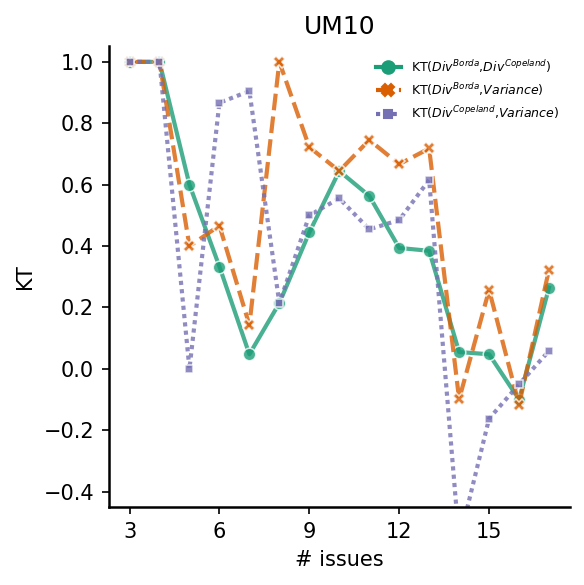

In [74]:
#Figure1: kendall-tau on the vertical axis, 
# number of individuals on horiz axis (fix number of items=20)
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,4), dpi=150)

g = sns.lineplot(data=subp, \
             x='number_issues', 
                 y='value',\
                 hue='Comparison',
             linewidth=2, 
                 style='Comparison',\
                 markers = True,
                 alpha=0.8, 
                 palette='Dark2', legend=True,
              ax=ax)
leg = g.legend(title="", frameon=False, fontsize=6, loc='upper right')
leg.get_title().set_position((-10, 0))
for line in leg.get_lines():
    line.set_linewidth(2)


ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylim(-0.45,1.05)
plt.title("UM10")
import matplotlib.ticker as mticker
ax.xaxis.set_major_locator(mticker.MultipleLocator(3))
ax.set_ylabel("KT")
ax.set_xlabel("# issues")
plt.tight_layout()
# plt.savefig("kt_div_between_agents.svg")
plt.savefig("figures/figure_experiment_1.pdf")
# ax[0].legend(title='Data',bbox_to_anchor=(1.2,0.9))
# ax[0].legend(title='Data',bbox_to_anchor=(1.2,0.9))